# SCANPY - PAGA

In [1]:
#conda activate scRNA
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
from matplotlib import rcParams
import scanpy as sc
import os
import csv
from astropy.io import ascii
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.cluster import DBSCAN
import warnings

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

warnings.filterwarnings('ignore')
code_dir = os.getcwd()
code_dir
sc.logging.print_versions()

/home/pipkin/anaconda3/envs/scanpy/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


scanpy==1.4.5.1 anndata==0.7.1 umap==0.3.10 numpy==1.18.1 scipy==1.4.1 pandas==1.0.1 scikit-learn==0.22.2.post1 statsmodels==0.11.1 python-igraph==0.8.0 louvain==0.6.1


-----

## Configuration

In [2]:
min_gene_nu, min_cell_nu = 500, 3 # Minimum cell number for cell filtering

min_g_nav, max_g_nav = 1200, 2500
min_m_nav, max_m_nav = 0.02, 0.08
min_c_nav, max_c_nav = 2000, 10000

min_g_a, max_g_a = 1000, 8000
min_m_a, max_m_a = 0.01, 0.07
min_c_a, max_c_a = 2000, 65000

fa_n_denoise, fa_pc_denoise = 200, 50
fa_n, fa_pc = 200, 50

max_n_per_cond = 900 # Maximun number of cells to use per condition

filter_celltypes = ["NWT"]

outname_base = "all--numSlt-rmWTNAV"

## Import data

In [3]:
os.chdir(code_dir)
wk_dir = "../1_1_SCANPY_PAGA"
os.chdir(wk_dir)

mtx_dir = '../1_0_cellranger_outs/outs/filtered_feature_bc_matrix'  # the directory with the `.mtx` file

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
results_file = './write/exp391_paga.h5ad'  # the file that will store the analysis results
sc.settings.set_figure_params(dpi=80)

adata = sc.read_10x_mtx(mtx_dir, var_names='gene_symbols', cache=True)
adata.X = adata.X.astype('float64')  # this is not required and results will be comparable without it
adata.var_names_make_unique()

wk_dir = "../1_1_SCANPY_PAGA/%s"%outname_base
os.chdir(wk_dir)

adata

... reading from cache file cache/..-1_0_cellranger_outs-outs-filtered_feature_bc_matrix-matrix.h5ad


AnnData object with n_obs × n_vars = 18353 × 22630 
    var: 'gene_ids', 'feature_types'

## 0. Pre-processing

### 0.1 Add in cell type data

In [4]:
cell_type_info = "../0_Pre-process/Cells_Type.csv"
with open(cell_type_info, 'r') as f:
  reader = csv.reader(f)
  cell_type_list = list(reader)
cell_type_list = [x[0] for x in cell_type_list]

adata.obs["cell_type"] = cell_type_list

# Filter out ambigous cells
adata = adata[adata.obs['cell_type'] != "Ambigous", :]

# Filter out cell types that we do not analyze this time
for i in filter_celltypes:
    adata = adata[adata.obs['cell_type'] != i, :]

In [5]:
if False:
    adata.write_loom("Exp391_countMatrix_celltype.loom")

### 0.2 Basic filtering & Mitochondrial filtering (Remove bad quality cells)

filtered out 811 cells that have less than 500 genes expressed


Trying to set attribute `.obs` of view, copying.


filtered out 7990 genes that are detected in less than 3 cells


Trying to set attribute `.obs` of view, copying.
... storing 'cell_type' as categorical
Trying to set attribute `.var` of view, copying.
... storing 'feature_types' as categorical


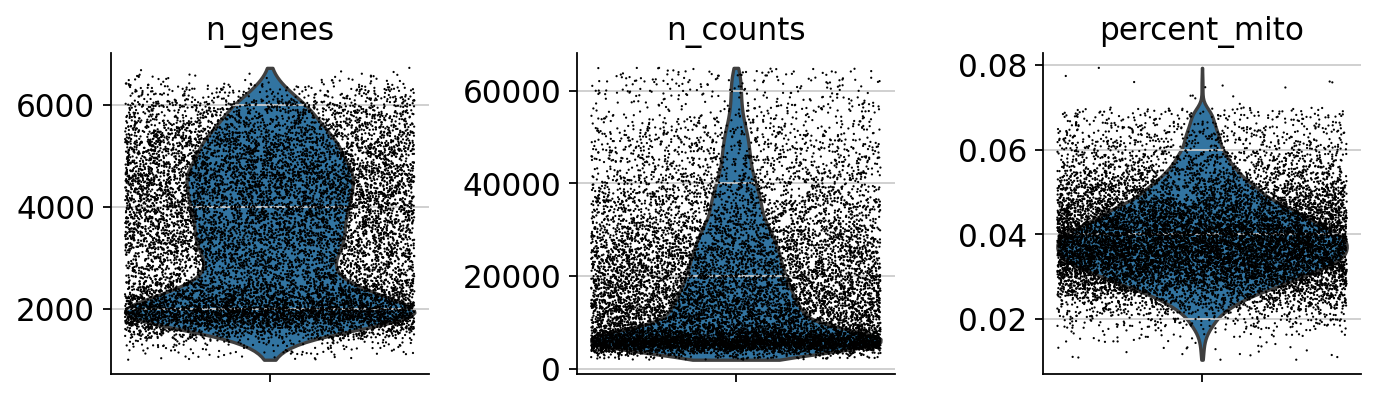

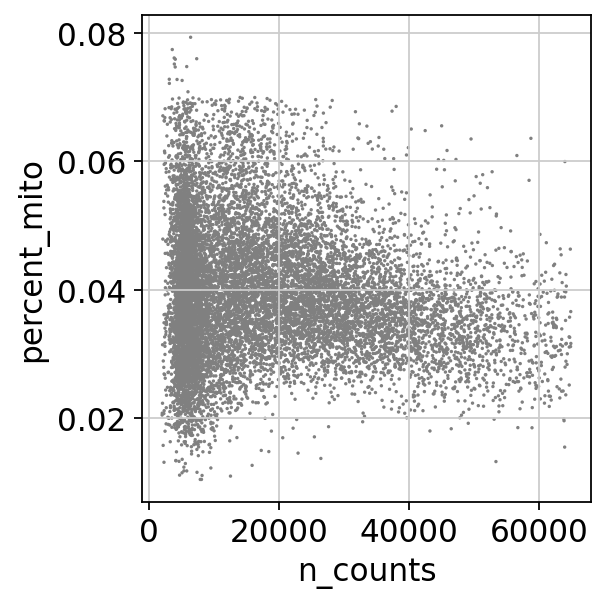

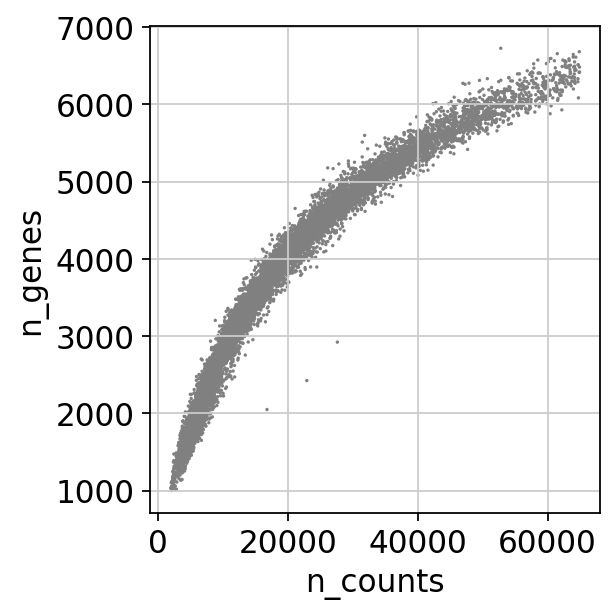

In [6]:
# Basic filtering
sc.pp.filter_cells(adata, min_genes=min_gene_nu)
sc.pp.filter_genes(adata, min_cells=min_cell_nu)

# Mitochondrial genes
mito_genes = adata.var_names.str.startswith('mt-')
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
adata.obs['percent_mito'] = np.sum(adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1).A1

###----- Naive cell filter
#sc.pl.violin(adata[adata.obs['cell_type']=="NP14B"], ['n_genes', 'n_counts', 'percent_mito'], jitter=0.4, multi_panel=True)
#sc.pl.scatter(adata[adata.obs['cell_type']=="NP14B"], x='n_counts', y='percent_mito')
#sc.pl.scatter(adata[adata.obs['cell_type']=="NP14B"], x='n_counts', y='n_genes')
use_list = []
for i in range(len(adata.obs)):
    if adata.obs['cell_type'][i] != "NP14B":
        use_list.append(True)
    else:
        i_genes = ((adata.obs['n_genes'][i] >= min_g_nav) and (adata.obs['n_genes'][i] <= max_g_nav))
        i_mito = ((adata.obs['percent_mito'][i] >= min_m_nav) and (adata.obs['percent_mito'][i] <= max_m_nav))
        i_c = ((adata.obs['n_counts'][i] >= min_c_nav) and (adata.obs['n_counts'][i] <= max_c_nav))
        if all([i_genes, i_mito, i_c]):
            use_list.append(True)
        else:
            use_list.append(False)
adata = adata[use_list, :]

###----- Activated cell filter
#sc.pl.violin(adata[adata.obs['cell_type']!="NP14B"], ['n_genes', 'n_counts', 'percent_mito'], jitter=0.4, multi_panel=True)
#sc.pl.scatter(adata[adata.obs['cell_type']!="NP14B"], x='n_counts', y='percent_mito')
#sc.pl.scatter(adata[adata.obs['cell_type']!="NP14B"], x='n_counts', y='n_genes')
use_list = []
for i in range(len(adata.obs)):
    if adata.obs['cell_type'][i] == "NP14B":
        use_list.append(True)
    else:
        i_genes = ((adata.obs['n_genes'][i] >= min_g_a) and (adata.obs['n_genes'][i] <= max_g_a))
        i_mito = ((adata.obs['percent_mito'][i] >= min_m_a) and (adata.obs['percent_mito'][i] <= max_m_a))
        i_c = ((adata.obs['n_counts'][i] >= min_c_a) and (adata.obs['n_counts'][i] <= max_c_a))
        if all([i_genes, i_mito, i_c]):
            use_list.append(True)
        else:
            use_list.append(False)
adata = adata[use_list, :]

sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'], jitter=0.4, multi_panel=True)
sc.pl.scatter(adata, x='n_counts', y='percent_mito')
sc.pl.scatter(adata, x='n_counts', y='n_genes')

### 0.3 Normalization

In [7]:
# Total-count normalize the data matrix to 10,000 reads per cell, so the counts become comparable among cells
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)

#####---------- Write files for all genes
if False:
    raw_array = adata.X.toarray()
    pd_raw_df = pd.DataFrame(raw_array)
    pd_raw_df.columns = list(adata.var.index.values)
    col_names = list(pd_raw_df.columns.values)
    drop_cols = []
    for i in range(0, len(col_names)):
        if max(pd_raw_df[col_names[i]]) < 10:
            drop_cols.append(col_names[i])
    pd_raw_df = pd_raw_df.drop(columns=drop_cols)
    pd_raw_df.index = list(adata.obs.index.values)
    pd_raw_df.to_csv("../all_norm_counts_named_c10.csv")

# Logarithmize the data
sc.pp.log1p(adata)
if False:
    raw_array = adata.X.toarray()
    pd_raw_df = pd.DataFrame(raw_array)
    pd_raw_df.columns = list(adata.var.index.values)
    col_names = list(pd_raw_df.columns.values)
    pd_raw_df.index = list(adata.obs.index.values)
    pd_raw_df.to_csv("../all_norm_counts_named_log.csv") 

###----- Save Logrithmized & Scaled & Low cutoff Highly variable data -- For Harmony analysis
if False:
    sc.pp.highly_variable_genes(adata, min_mean=0.002, max_mean=10, min_disp=0.1)
    sc.pl.highly_variable_genes(adata)
    adata = adata[:, adata.var['highly_variable']]
    sc.pp.regress_out(adata, ['n_counts'])
    sc.pp.scale(adata, max_value=10)
    
    raw_array = adata.X
    pd_raw_df = pd.DataFrame(raw_array)
    pd_raw_df.columns = list(adata.var.index.values)
    col_names = list(pd_raw_df.columns.values)
    pd_raw_df.index = list(adata.obs.index.values)
    pd_raw_df.to_csv("../all_norm_counts_named_log_scaled.csv")     

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


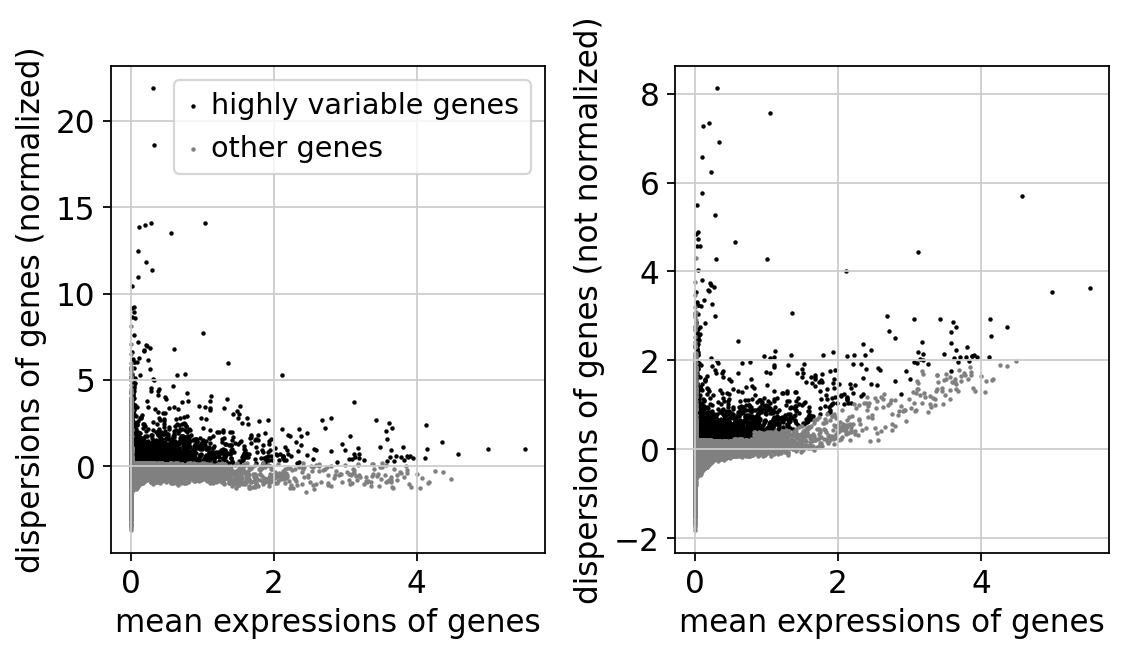

regressing out ['n_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:38)


In [8]:
# Set the .raw attribute of AnnData object to the logarithmized raw gene expression 
# For later use in differential testing and visualizations of gene expression
adata.raw = adata

# Identify highly-variable genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=7, min_disp=0.2)
sc.pl.highly_variable_genes(adata)
adata = adata[:, adata.var['highly_variable']]
sc.pp.regress_out(adata, ['n_counts'])
sc.pp.scale(adata, max_value=10)

### 0.4 Outlier detection

computing PCA with n_comps = 50
    on highly variable genes
    finished (0:00:05)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:23)
drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fa', graph_drawing coordinates (adata.obsm) (0:01:54)


... storing 'y_pred' as categorical


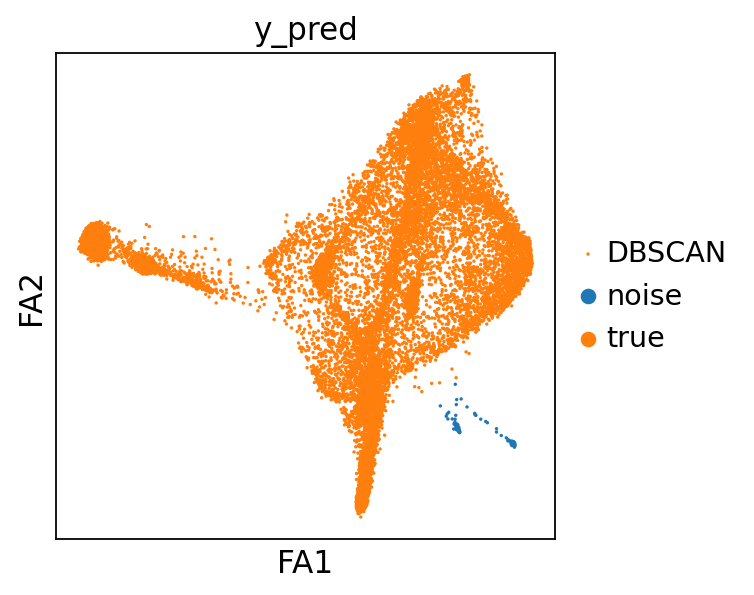

Counter({'true': 12685, 'noise': 114})


In [9]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=fa_n_denoise, n_pcs=fa_pc_denoise)
sc.tl.draw_graph(adata)

adata_fa = pd.DataFrame(adata.obsm["X_draw_graph_fa"])
clustering = DBSCAN(eps=11000, min_samples=70).fit(adata.obsm["X_draw_graph_fa"])
y_pred = ["noise" if x == -1 else "true" for x in list(clustering.labels_)]
Counter(y_pred)
adata.obs["y_pred"] = y_pred
sc.pl.draw_graph(adata, color='y_pred', label="DBSCAN")

print(Counter(list(y_pred)))
adata = adata[adata.obs["y_pred"] == "true"]

### Save obs

In [10]:
if False:
    adata.obs.to_csv("obs_qcFlt-outFlt.csv")

### 0.5 Cell number capping

In [11]:
if True:
    # Use Specified number of cells per condition
    cell_type_use = []
    cell_type_set = list(set(list(adata.obs['cell_type'])))
    print(Counter(list(adata.obs['cell_type'])))
    cell_type_dict = {key:0 for key in cell_type_set}
    for i in list(adata.obs['cell_type']):
        cell_type_dict[i] += 1
        if cell_type_dict[i] <= max_n_per_cond:
            cell_type_use.append("Yes")
        else:
            cell_type_use.append("No")

    adata.obs['use'] = cell_type_use
    adata = adata[adata.obs['use'] == "Yes", :]
    print(Counter(list(adata.obs['cell_type'])))

Trying to set attribute `.obs` of view, copying.


Counter({'A5T': 2922, 'A5P': 2665, 'C5P': 2452, 'A8T': 1574, 'A8P': 1212, 'NP14B': 957, 'C8P': 903})
Counter({'C8P': 900, 'C5P': 900, 'NP14B': 900, 'A8T': 900, 'A8P': 900, 'A5P': 900, 'A5T': 900})


## 1. Clustering and PAGA

In [12]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=fa_n, n_pcs=fa_pc)
sc.tl.draw_graph(adata)

computing PCA with n_comps = 50
    on highly variable genes
    finished (0:00:05)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:04)
drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fa', graph_drawing coordinates (adata.obsm) (0:00:48)


... storing 'use' as categorical


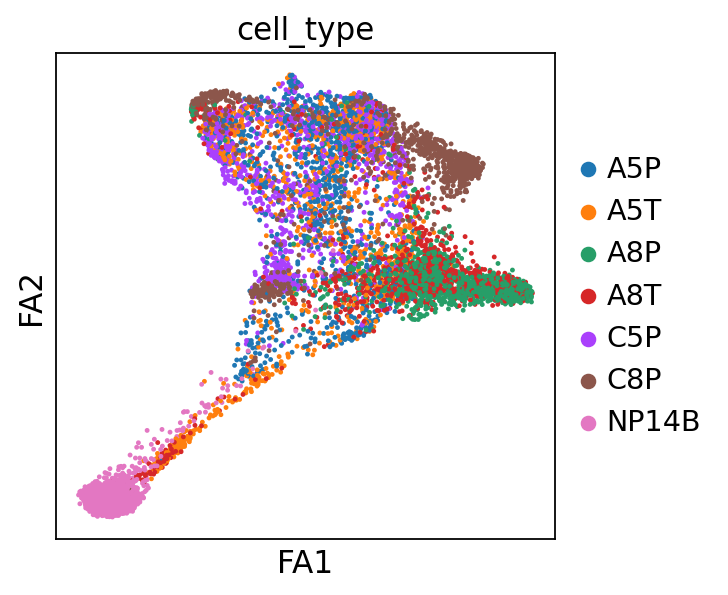

In [13]:
sc.pl.draw_graph(adata, color='cell_type')

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 9 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:06)
----------
Counter({'0': 1124, '1': 1055, '2': 752, '3': 668, '4': 643, '5': 614, '6': 523, '7': 470, '8': 451})
----------
running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:01)
--> added 'pos', the PAGA positions (adata.uns['paga'])


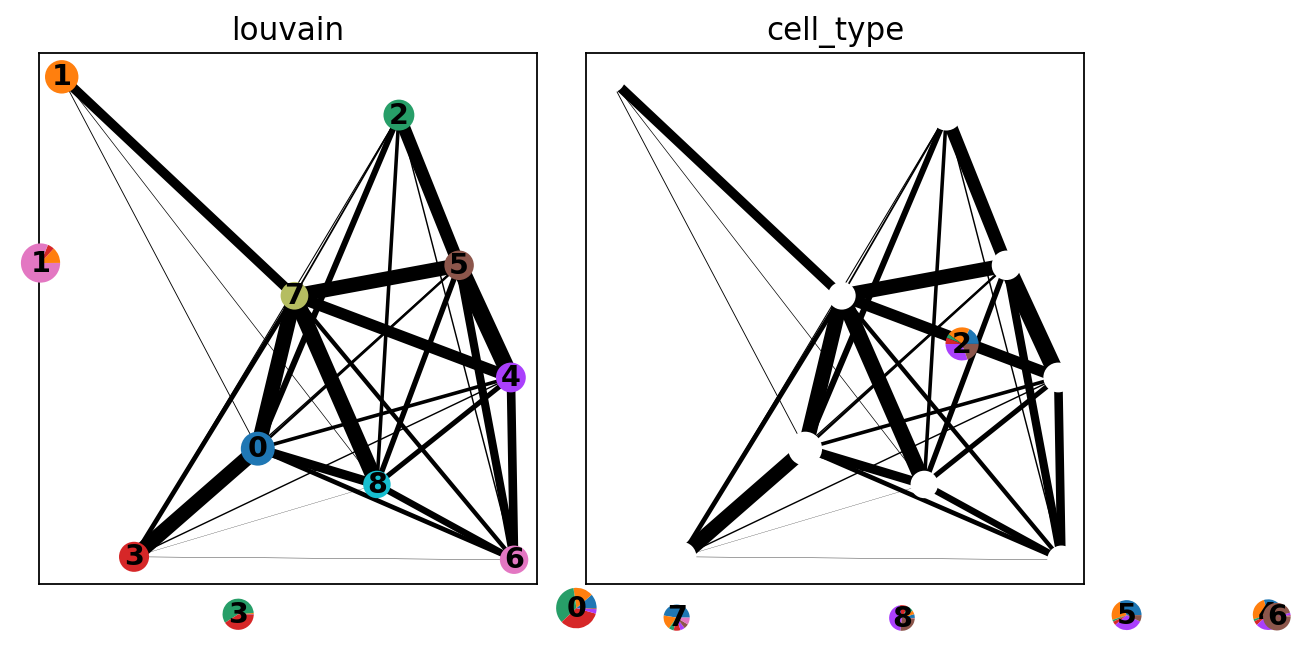

In [14]:
sc.tl.louvain(adata, resolution=1.8)
print("----------")
print(Counter(list(adata.obs['louvain'])))
print("----------")
sc.tl.paga(adata, groups='louvain')
sc.pl.paga(adata, color=['louvain', 'cell_type'])

--> added 'pos', the PAGA positions (adata.uns['paga'])


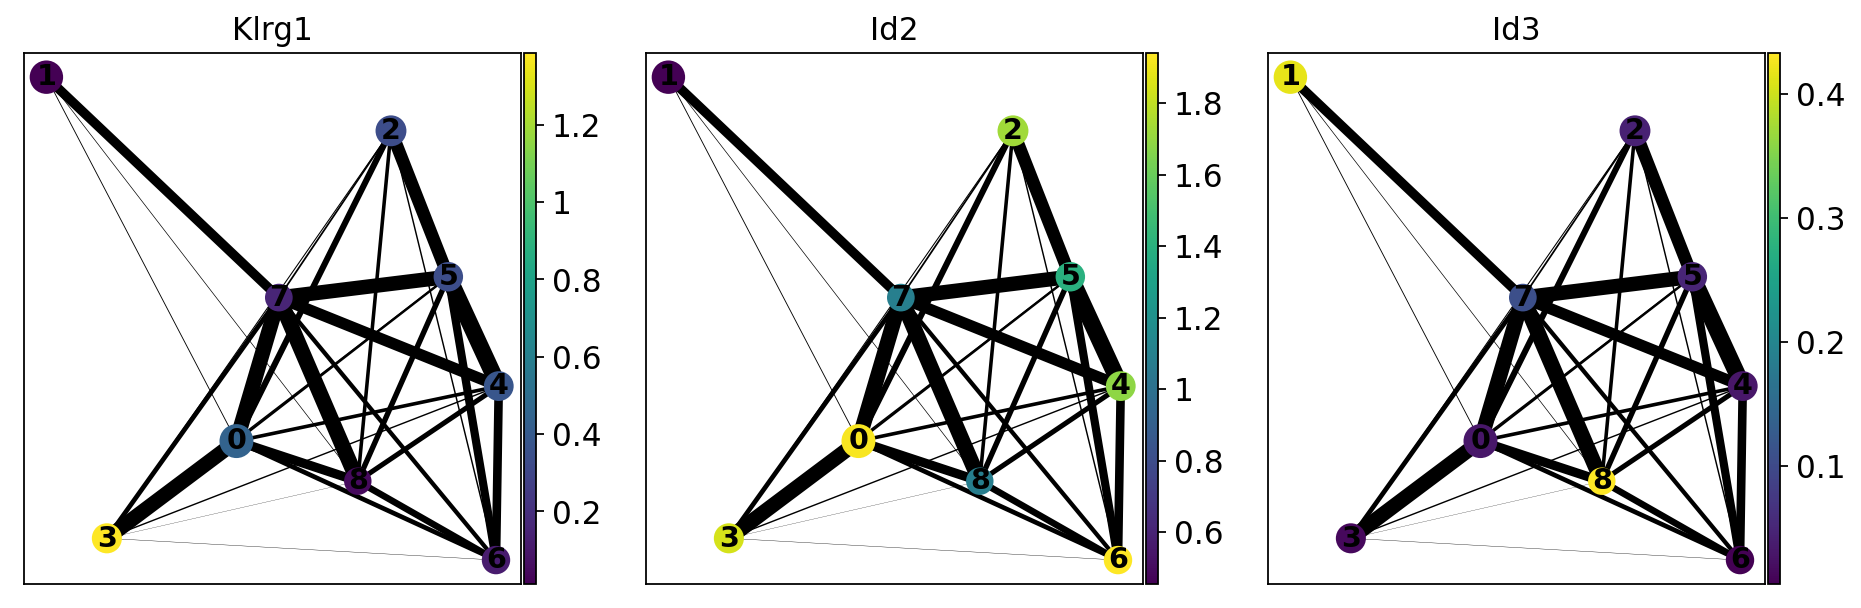

In [15]:
sc.pl.paga(adata,color=['Klrg1','Id2', 'Id3'])

--> added 'pos', the PAGA positions (adata.uns['paga'])


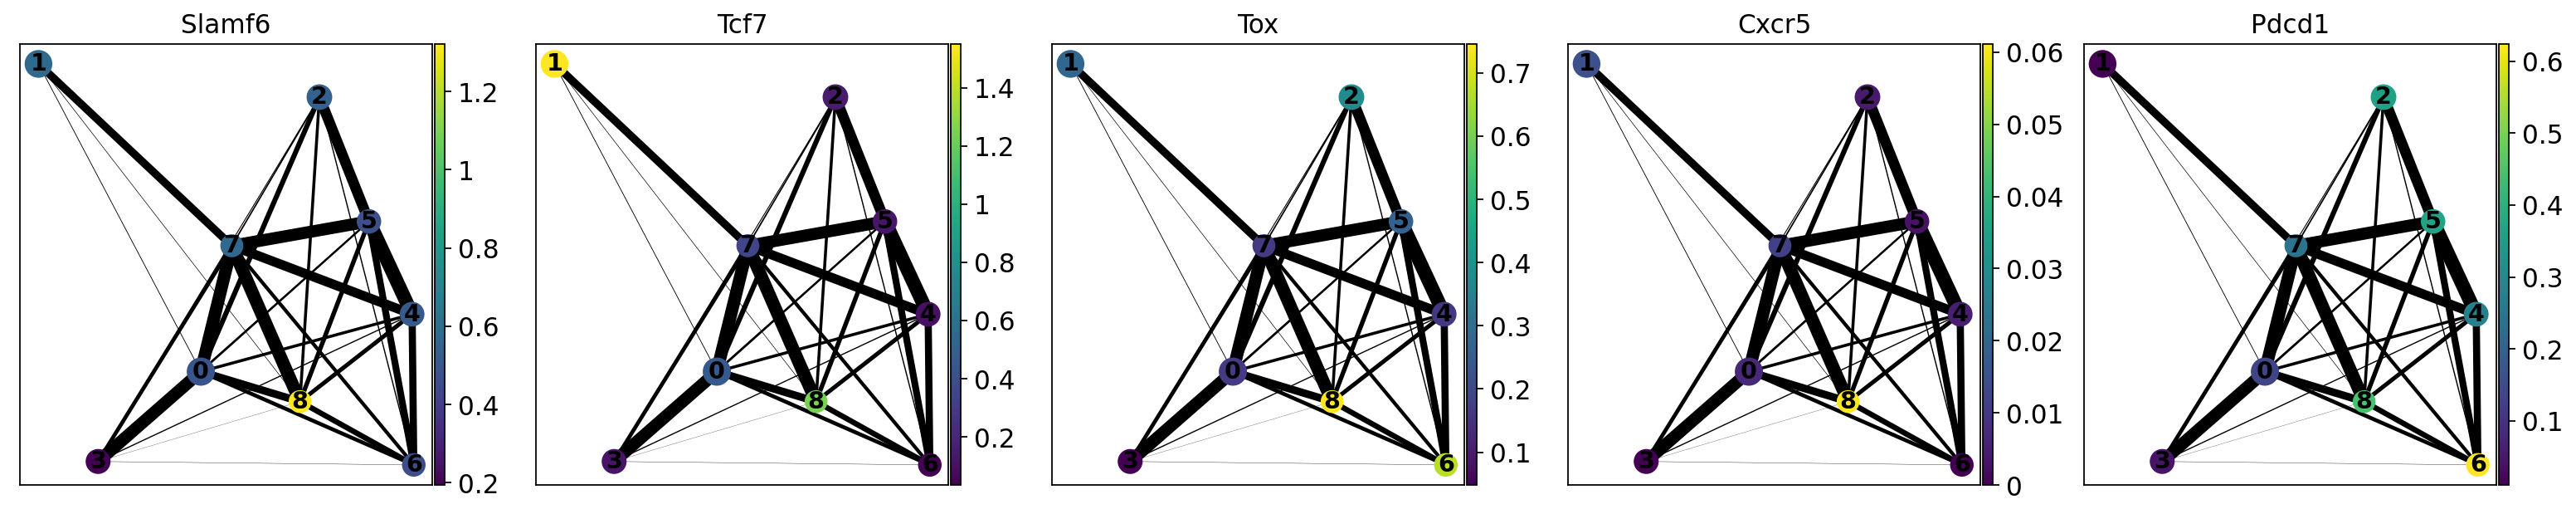

In [16]:
sc.pl.paga(adata, color=['Slamf6', 'Tcf7', 'Tox', 'Cxcr5', 'Pdcd1'])

--> added 'pos', the PAGA positions (adata.uns['paga'])


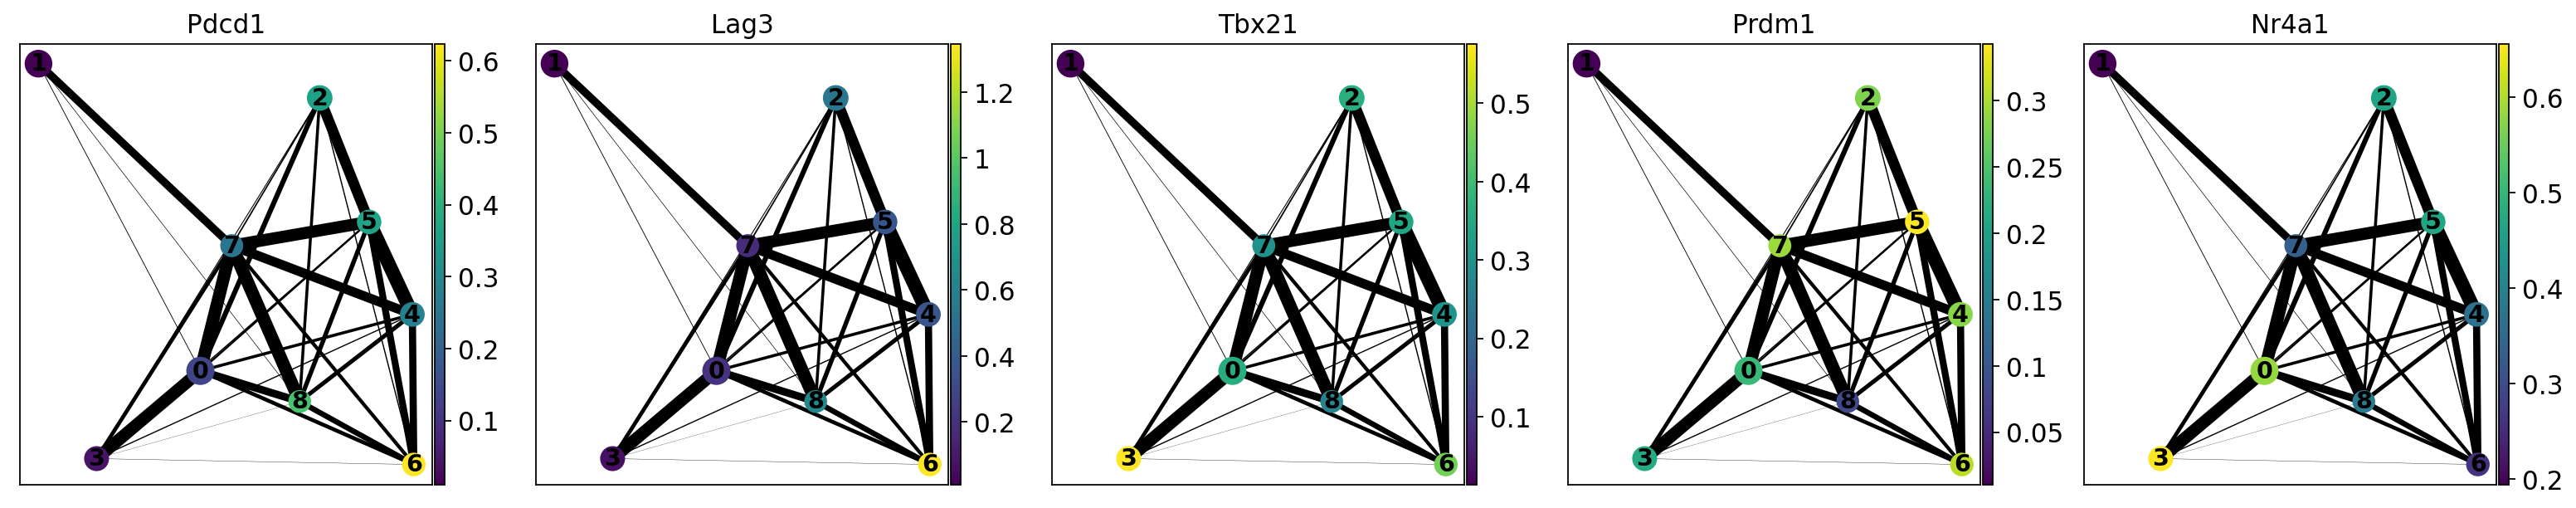

In [17]:
sc.pl.paga(adata, color=['Pdcd1',  'Lag3', 'Tbx21', 'Prdm1', 'Nr4a1'])

--> added 'pos', the PAGA positions (adata.uns['paga'])


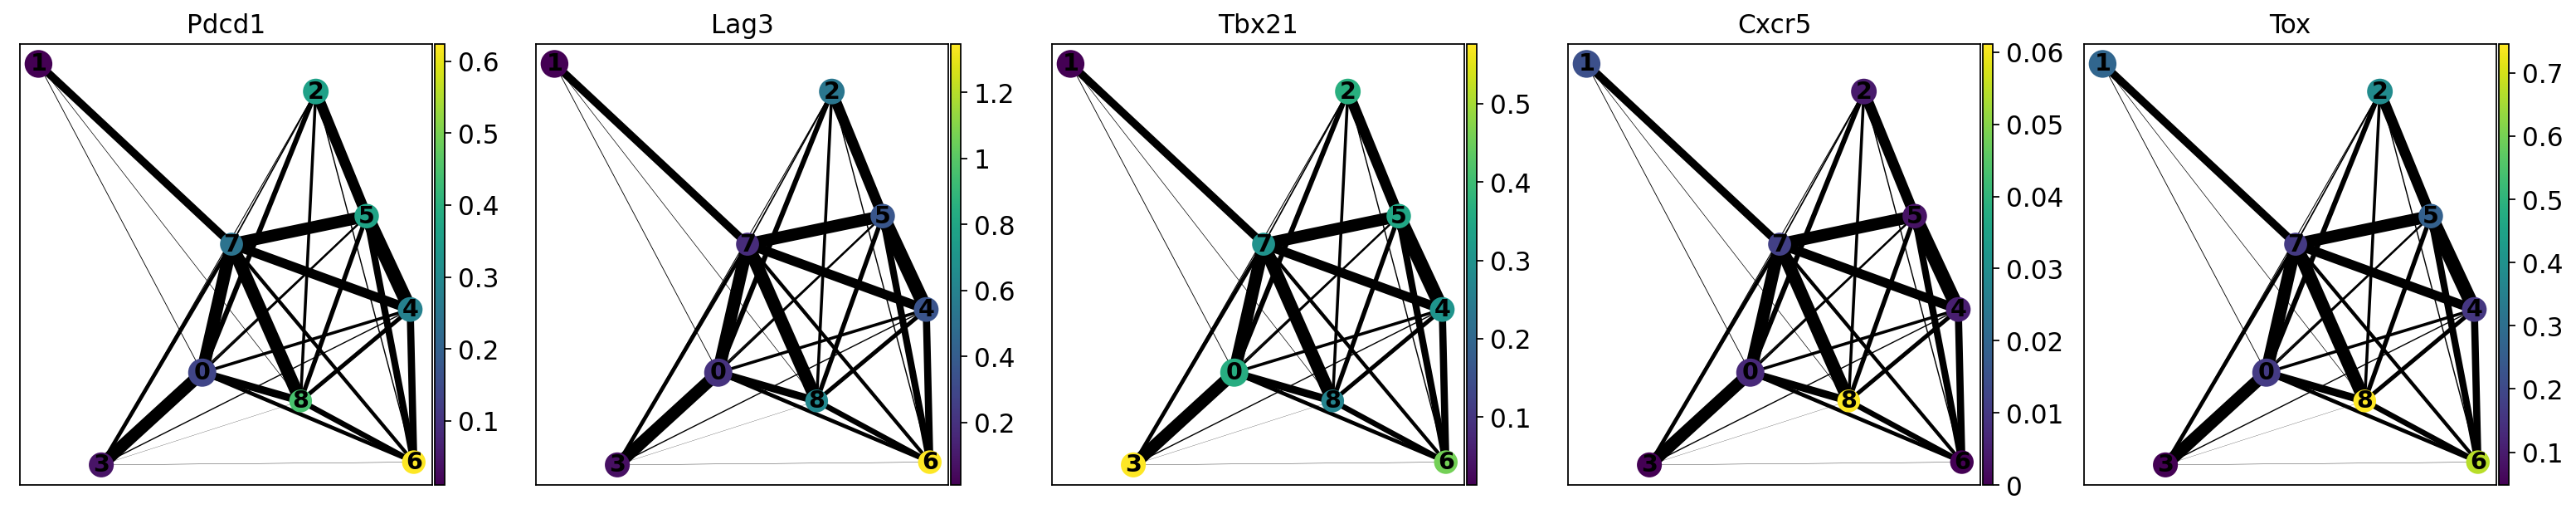

In [18]:
sc.pl.paga(adata, color=['Pdcd1',  'Lag3', 'Tbx21', 'Cxcr5', 'Tox'])

--> added 'pos', the PAGA positions (adata.uns['paga'])


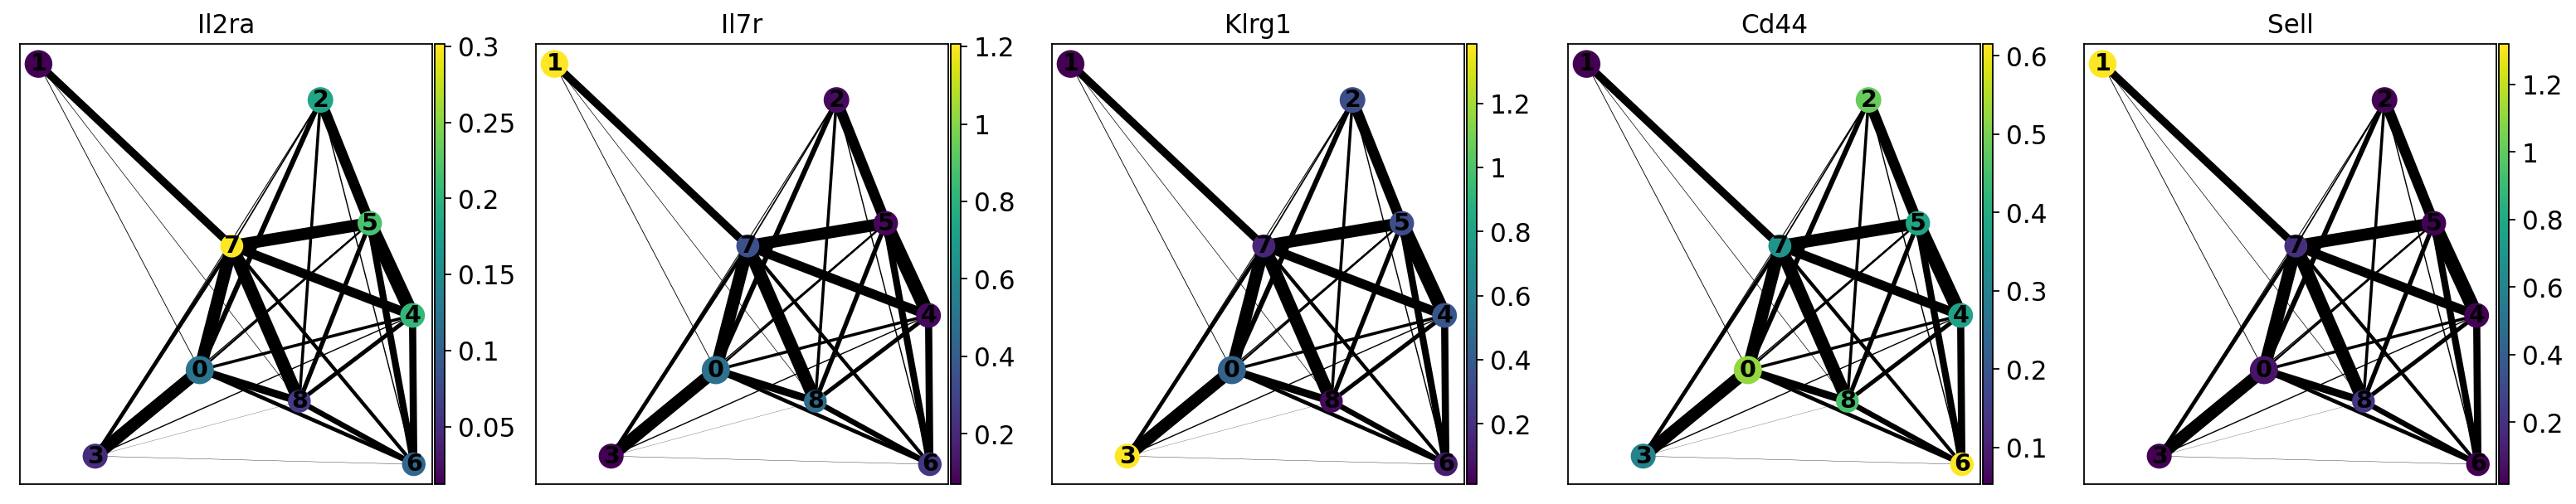

In [19]:
sc.pl.paga(adata, color=['Il2ra', 'Il7r','Klrg1','Cd44','Sell'])

--> added 'pos', the PAGA positions (adata.uns['paga'])


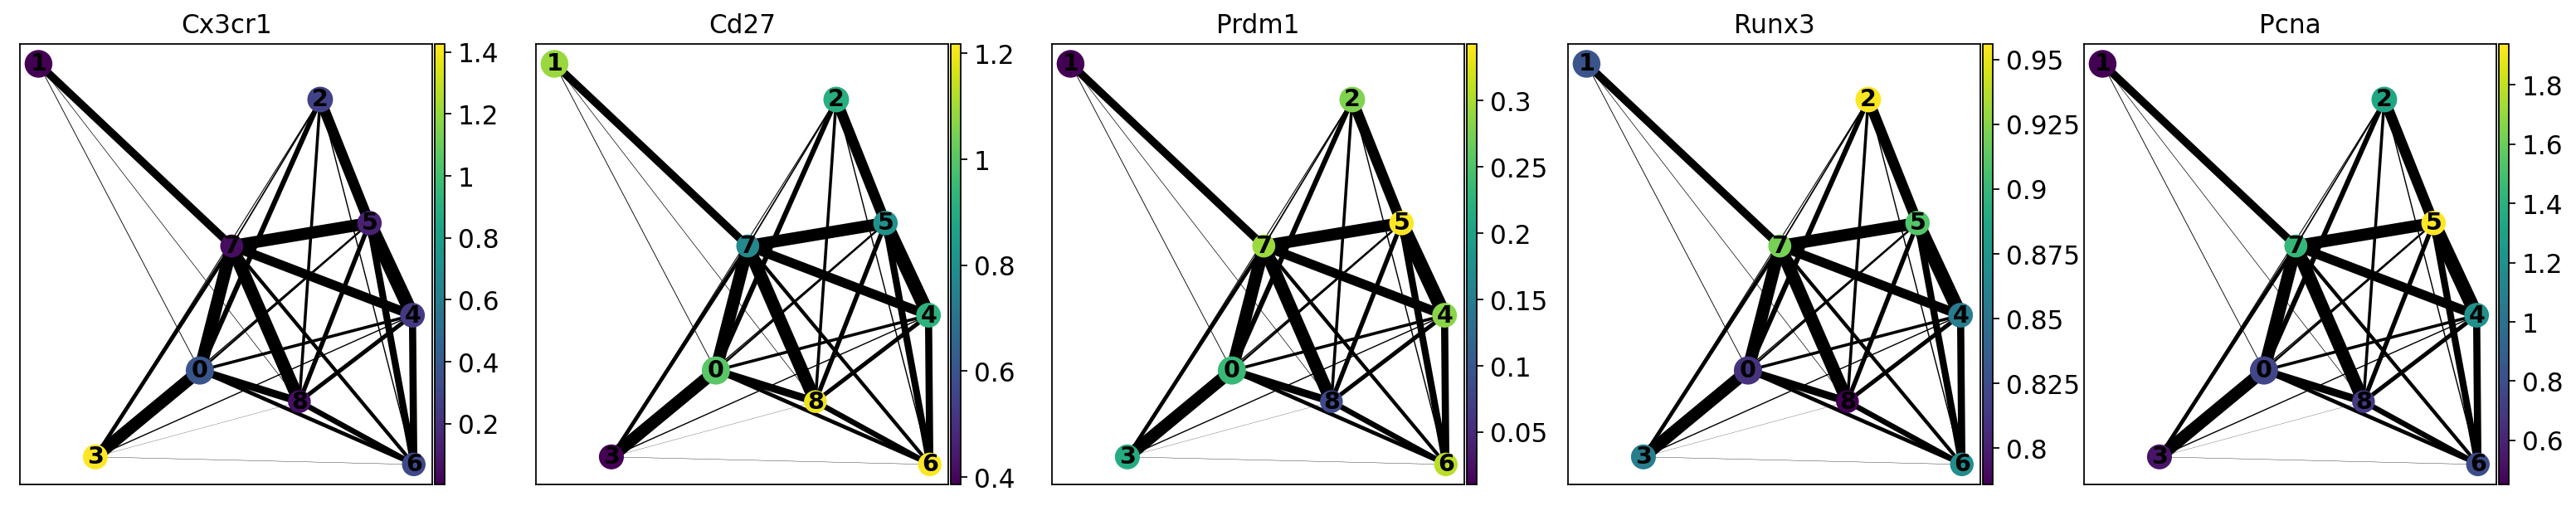

In [20]:
sc.pl.paga(adata, color=['Cx3cr1','Cd27', 'Prdm1', 'Runx3','Pcna'])

--> added 'pos', the PAGA positions (adata.uns['paga'])


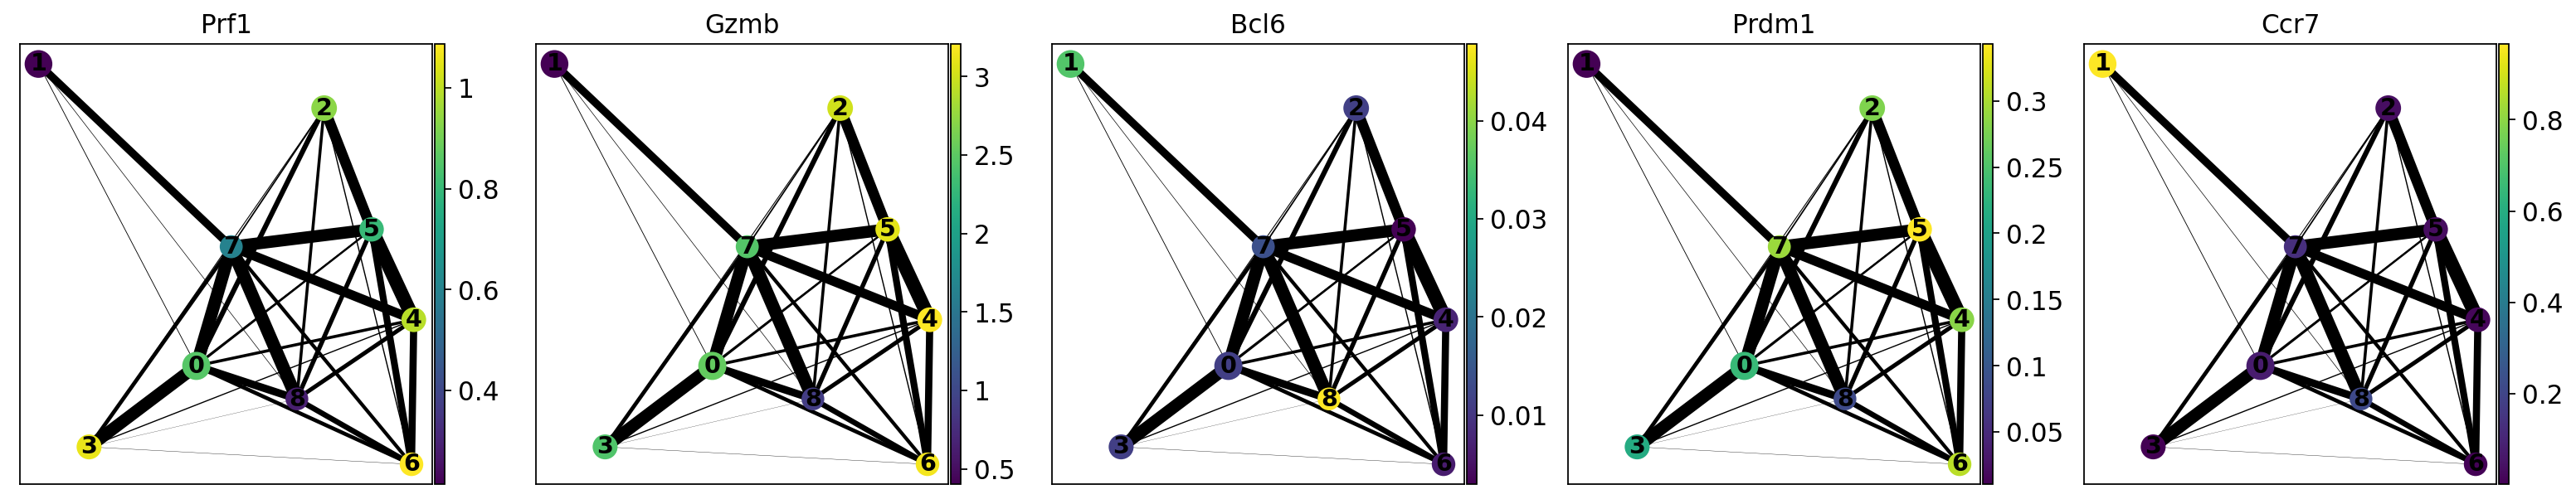

In [21]:
sc.pl.paga(adata, color=['Prf1', 'Gzmb', 'Bcl6','Prdm1','Ccr7'])

--> added 'pos', the PAGA positions (adata.uns['paga'])


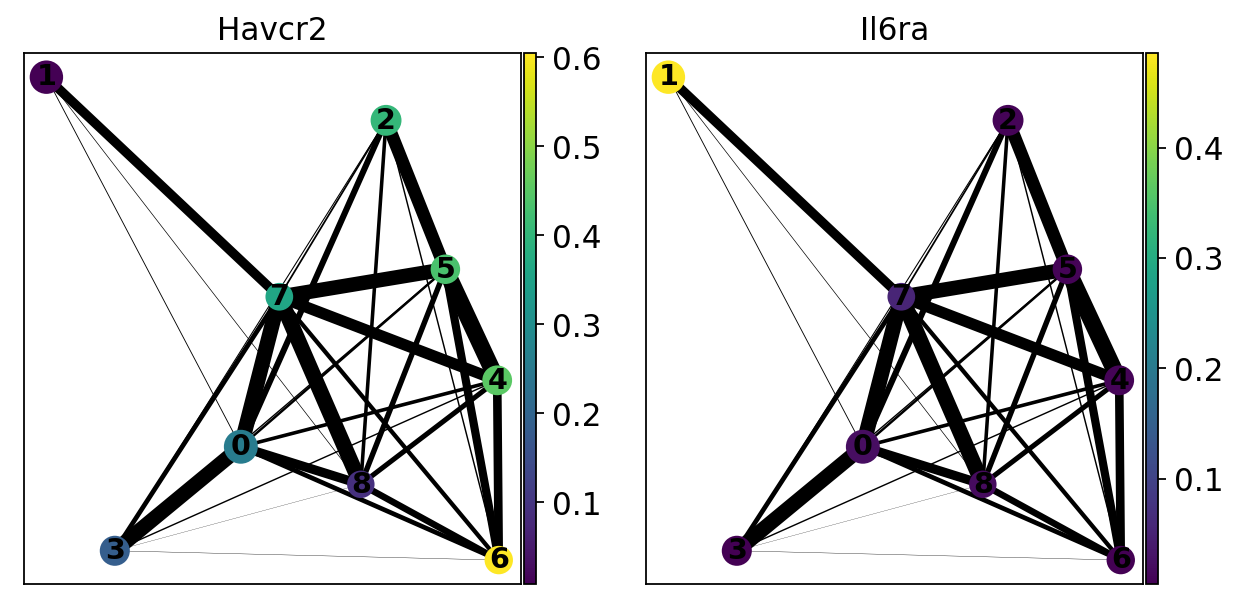

In [22]:
sc.pl.paga(adata, color=['Havcr2', 'Il6ra'])

### 1.1 Recomputing the embedding using PAGA-initialization

drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fa', graph_drawing coordinates (adata.obsm) (0:00:47)


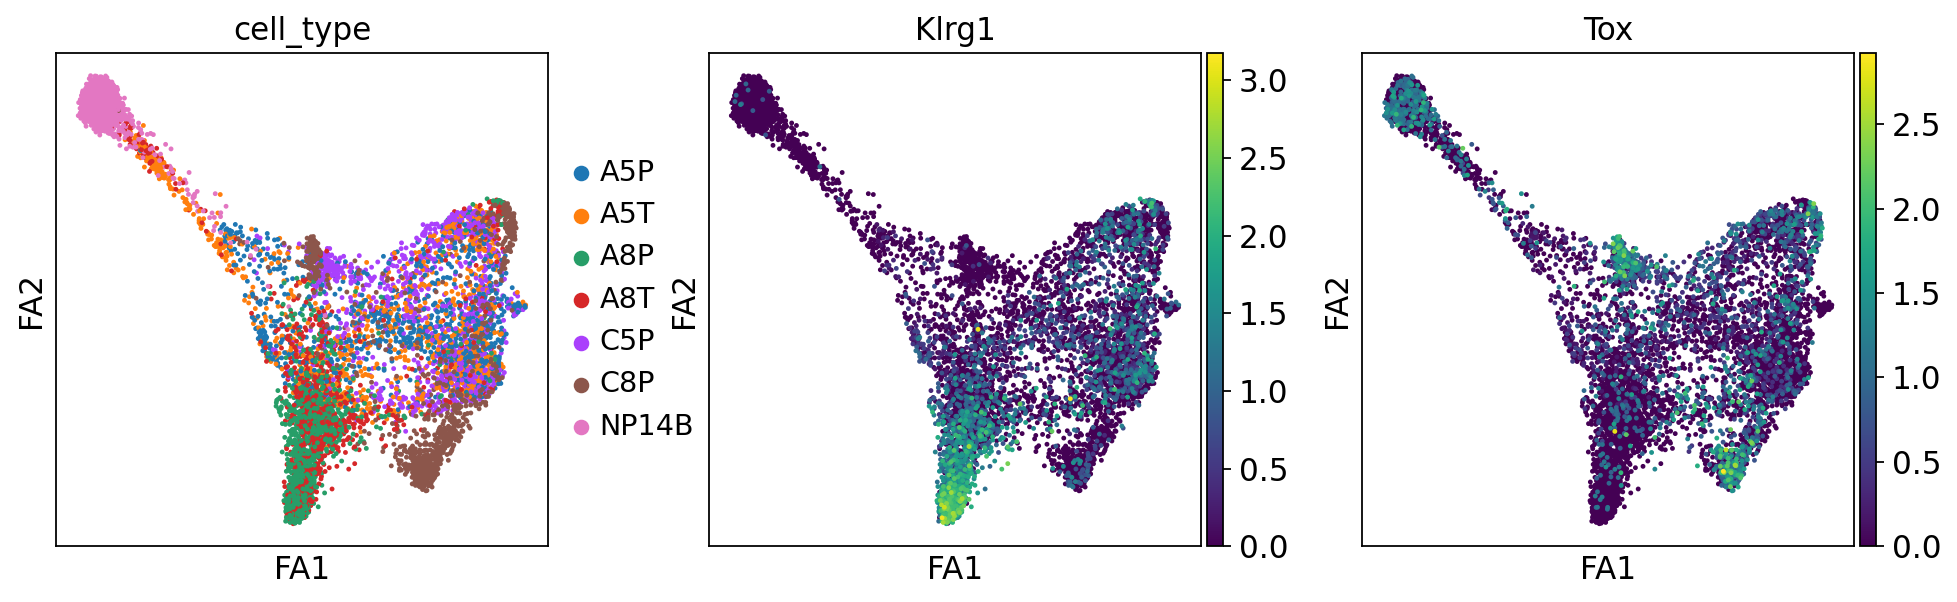

In [23]:
sc.tl.draw_graph(adata, init_pos='paga')
sc.pl.draw_graph(adata, color=['cell_type', 'Klrg1', 'Tox'])

### 1.2 Reconstructing gene changes along PAGA paths for a given set of genes

In [24]:
p14nav_array = np.flatnonzero(adata.obs['cell_type']  == 'NP14B')
louvain0_array = np.flatnonzero(adata.obs['louvain']  == '1')
p14nav_louvain0_array = np.intersect1d(p14nav_array, louvain0_array)
adata.uns['iroot'] = p14nav_louvain0_array[0]

computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.9854836  0.9568046  0.937052   0.9221436  0.91748565
     0.8799829  0.87409645 0.862677   0.8519796  0.84474915 0.83092105
     0.8249812  0.8207532  0.800914  ]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:01)
computing Diffusion Pseudotime using n_dcs=10
    finished: added
    'dpt_pseudotime', the pseudotime (adata.obs) (0:00:00)


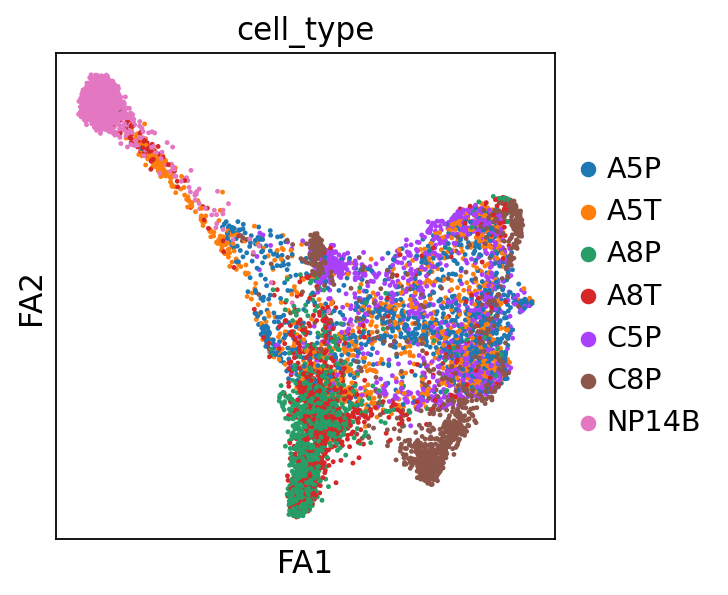

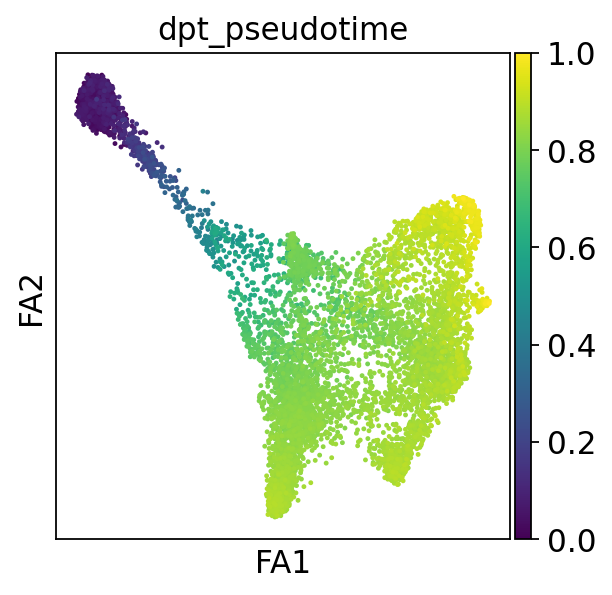

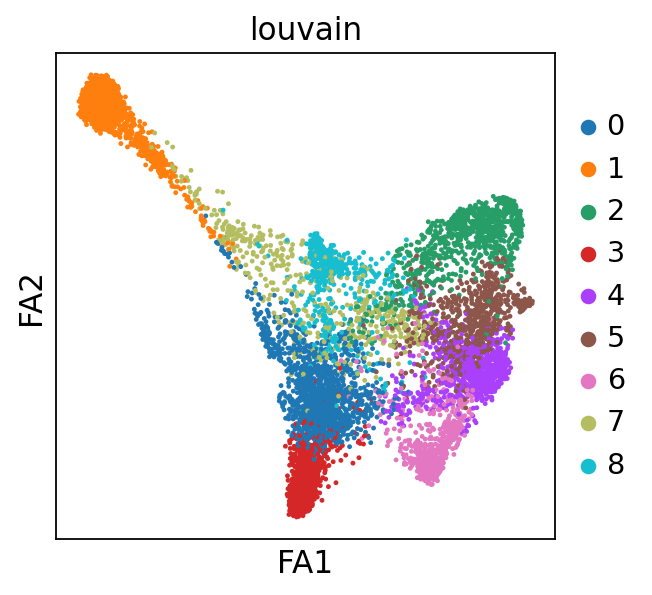

In [25]:
sc.tl.dpt(adata)
sc.pl.draw_graph(adata, color=['cell_type'])
sc.pl.draw_graph(adata, color=['dpt_pseudotime'])
sc.pl.draw_graph(adata, color=['louvain'])

*Rename clusters with Pseudotime order*

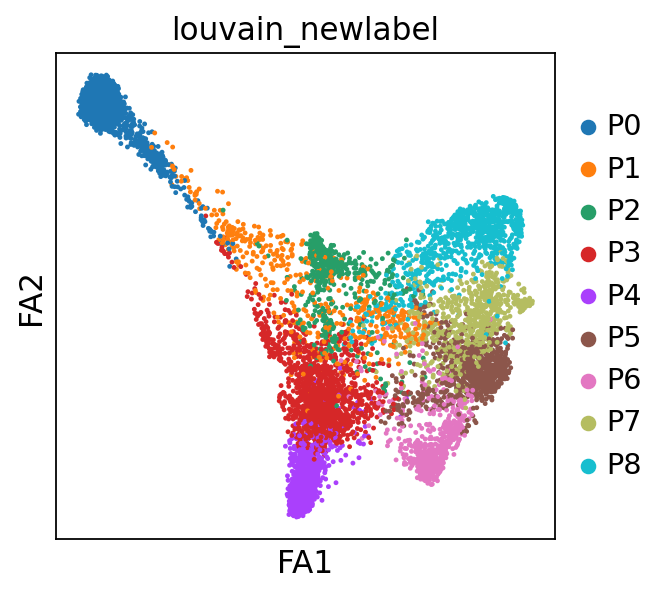

In [46]:
newlabel_info = '/media/pipkin/Yolanda/Exp391_Acute-Chronic_SC/z_Info/Exp391_newLabels.csv'
newlabel_tb = pd.read_csv(newlabel_info)
new_labels = list(newlabel_tb['new_label'])
old_labels = list(newlabel_tb['old_label'])
adata.obs['louvain_newlabel'] = [new_labels[old_labels.index("L%s"%str(x))] for x in adata.obs['louvain'].values]

sc.pl.draw_graph(adata, color=['louvain_newlabel'])

### Save object

In [28]:
if True:
    adata.write_h5ad("Exp391.h5ad")

... storing 'louvain_newlabel' as categorical


-----

## 2. Write summary

In [25]:
###----- Calculate cell type distrubution
cell_type_uniq = list(set(list(adata.obs['cell_type'])))
louvain_uniq = list(set(list(adata.obs['louvain'])))
louvain_uniq_use = list( range(0,(max([int(i) for i in louvain_uniq]) + 1)))
louvain_type_count_tb = pd.DataFrame(data = {'louvain': louvain_uniq_use})
louvain_type_pctg_tb = pd.DataFrame(data = {'louvain': louvain_uniq_use})
for type_i in cell_type_uniq:
    #print(type_i)
    number_i = []
    pctg_i = []
    typ_i_louvain = list(adata.obs[adata.obs["cell_type"] == type_i]["louvain"])
    for i in louvain_uniq_use:
        #print(i)
        louvain_i_number = typ_i_louvain.count(str(i))
        louvain_i_pctg = float(louvain_i_number)*100/len(typ_i_louvain)
        number_i.append(louvain_i_number)
        pctg_i.append(louvain_i_pctg)
    louvain_type_count_tb[type_i] = number_i
    louvain_type_pctg_tb[type_i] = pctg_i
louvain_type_pctg_tb.to_csv("%s_Louvain--CellType_pctg.csv"%outname_base, index=False)
louvain_type_count_tb.to_csv("%s_Louvain--CellType_count.csv"%outname_base, index=False)

In [26]:
###----- Write Paga Connectivity
paga_connect = pd.DataFrame(adata.uns['paga']['connectivities'].A)
paga_connect_tree = pd.DataFrame(adata.uns['paga']['connectivities_tree'].A)
paga_pos = pd.DataFrame(adata.uns['paga']['pos'])

paga_connect.to_csv("%s_paga_connect.csv"%outname_base, sep=',')
paga_connect_tree.to_csv("%s_paga_connect_tree.csv"%outname_base, sep=',')
paga_pos.to_csv("%s_paga_pos.csv"%outname_base, sep=',')

In [39]:
###----- Obs average
adata.obs['counts_per_gene'] = adata.obs['n_counts'] / adata.obs['n_genes']
# Average by louvain
adata_obs_mean = adata.obs.groupby(['louvain']).mean()
adata_obs_mean = adata_obs_mean.sort_values(by="dpt_pseudotime")
adata_obs_mean.to_csv("%s_obs_louvainAvg.csv"%outname_base)
adata_obs_mean

n_genes  percent_mito      n_counts  dpt_pseudotime  \
louvain                                                            
1        1872.564929      0.045522   5988.368652        0.074863   
7        4542.280851      0.036670  33169.593750        0.653807   
8        3363.636364      0.046275  15693.809570        0.778458   
0        3126.587189      0.038034  16341.048828        0.796237   
3        1931.197605      0.034376   5611.547852        0.854012   
4        3677.723173      0.039384  17973.169922        0.857501   
6        2796.095602      0.036323  10161.870117        0.863111   
5        3905.845277      0.041711  20068.064453        0.866389   
2        4251.984043      0.039035  23168.115234        0.903993   

         counts_per_gene  
louvain                   
1               3.144001  
7               6.487342  
8               4.343655  
0               4.221774  
3               2.799559  
4               4.642606  
6               3.466149  
5               4.883231  
2               5.237567

In [40]:
# Average by cell type
adata_obs_mean = adata.obs.groupby(['cell_type']).mean()
adata_obs_mean = adata_obs_mean.sort_values(by="dpt_pseudotime")
adata_obs_mean.to_csv("%s_obs_ctAvg.csv"%outname_base)
adata_obs_mean

n_genes  percent_mito      n_counts  dpt_pseudotime  \
cell_type                                                            
NP14B      1846.673333      0.047555   5659.433105        0.057087   
A5T        3820.350000      0.036975  21978.251953        0.727747   
A8T        2278.058889      0.039065   7574.391113        0.784139   
A5P        4806.830000      0.038694  32454.052734        0.801883   
A8P        2195.688889      0.035341   6858.740234        0.834094   
C5P        4011.176667      0.043712  21332.462891        0.841367   
C8P        3101.852222      0.037692  12716.914062        0.861850   

           counts_per_gene  
cell_type                   
NP14B             3.049985  
A5T               5.210776  
A8T               3.145398  
A5P               6.418051  
A8P               2.967887  
C5P               5.039574  
C8P               3.807536

In [28]:
###----- Save whole object
adata.write_csvs(outname_base)

writing .csv files to all--numSlt-rmWTNAV


### 2.1 Summary plots -- louvain

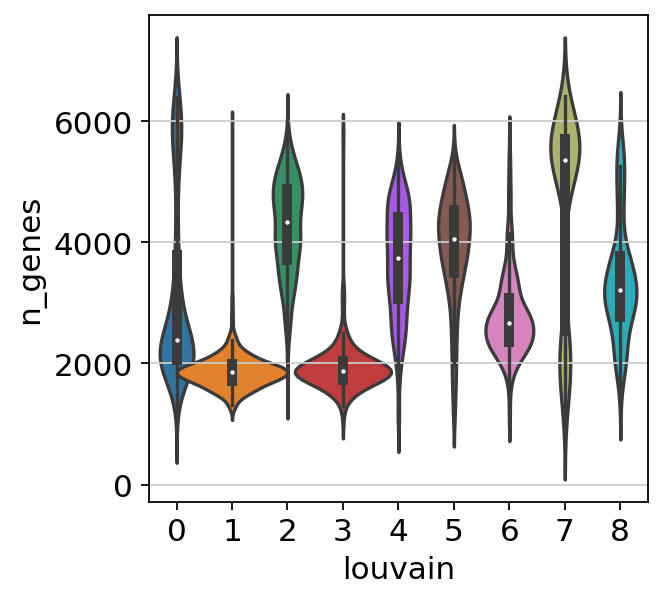

In [31]:
sns.violinplot(x="louvain", y="n_genes", data=adata.obs, width = 2)

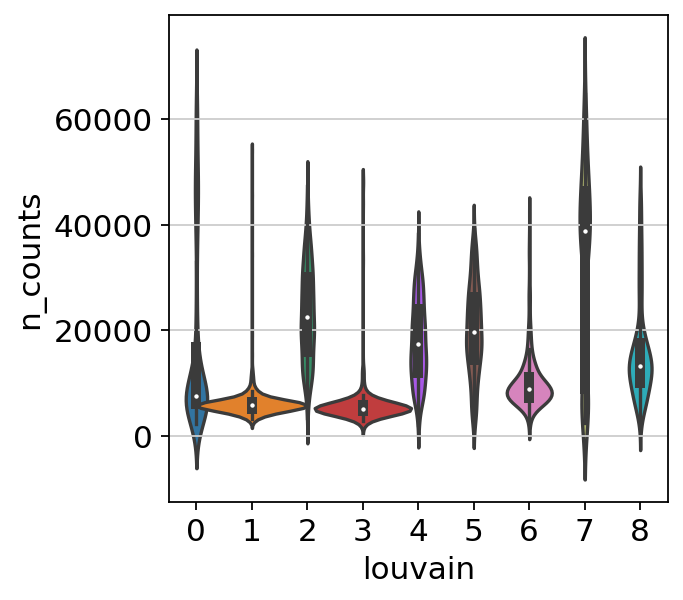

In [32]:
sns.violinplot(x="louvain", y="n_counts", data=adata.obs, width = 2)

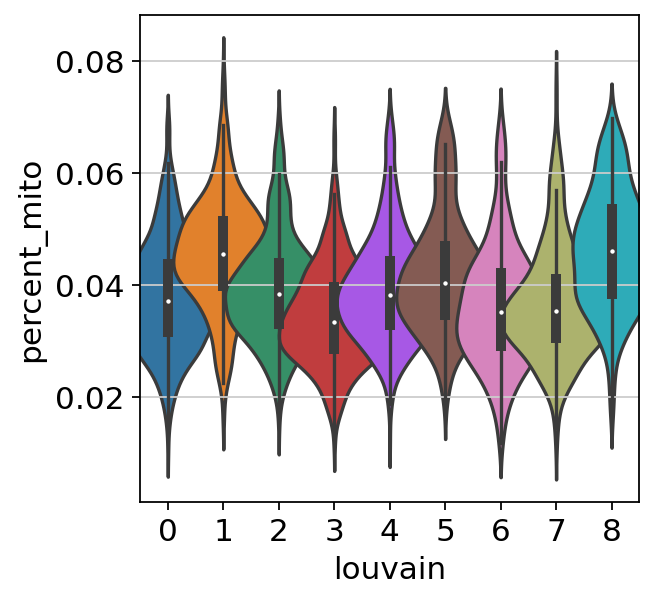

In [33]:
sns.violinplot(x="louvain", y="percent_mito", data=adata.obs, width = 2)

### 2.2 Summary plots -- cell type

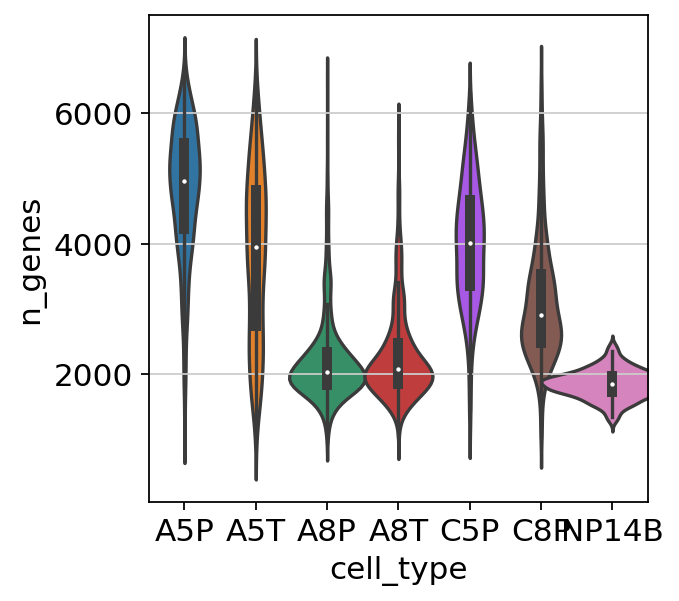

In [36]:
sns.violinplot(x="cell_type", y="n_genes", data=adata.obs, width = 2)

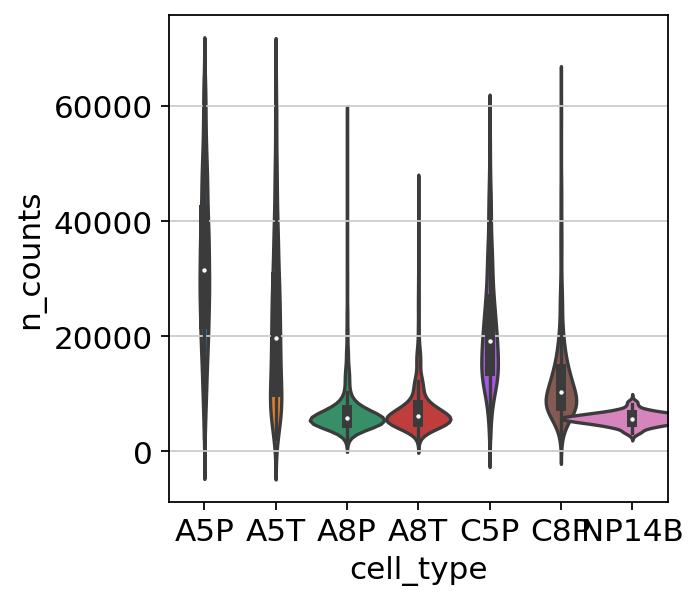

In [37]:
sns.violinplot(x="cell_type", y="n_counts", data=adata.obs, width = 2)

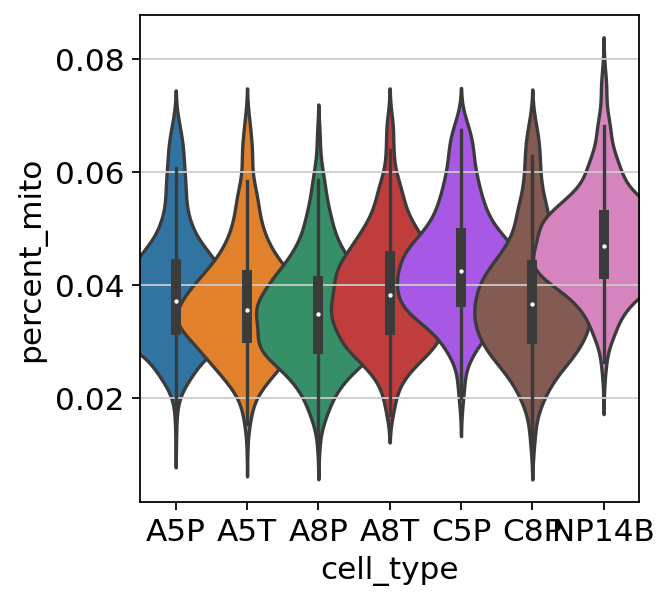

In [38]:
sns.violinplot(x="cell_type", y="percent_mito", data=adata.obs, width = 2)